# Starbucks Capstone Challenge

## Abstract

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Cleaning

### Portfolio

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
# Available channels
channels = ["email", "mobile", "social", "web"]

# Create a one hot encoding for channel type
portfolioWithChannelsEncoded = portfolio.copy()
for channel in channels:
    portfolioWithChannelsEncoded[channel] = portfolio["channels"].apply(lambda cs: 1*(channel in cs))

portfolio_df = portfolioWithChannelsEncoded.drop(columns="channels")

# Give a descriptive name
portfolio_df["code"] = portfolio_df["offer_type"].str[0] + "." + \
    portfolio_df["difficulty"].astype(str) + "."  + \
    portfolio_df["reward"].astype(str) + "."  + \
    portfolio_df["duration"].astype(str)

# Rename and order columns and rows
portfolio_df = portfolio_df.rename(columns={"id": "offer_id"})
cols = ["offer_id","code","offer_type","difficulty","reward","duration","email","mobile","social","web"]
assert set(cols) == set(portfolio_df.columns)
portfolio_df = portfolio_df[cols]
portfolio_df = portfolio_df.sort_values(["offer_type", "difficulty", "reward", "duration"])

portfolio_df

,offer_id,code,offer_type,difficulty,reward,duration,email,mobile,social,web
8,f19421c1d4aa40978ebb69ca19b0e20d,b.5.5.5,bogo,5,5,5,1,1,1,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,b.5.5.7,bogo,5,5,7,1,1,0,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,b.10.10.5,bogo,10,10,5,1,1,1,1
0,ae264e3637204a6fb9bb56bc8210ddfd,b.10.10.7,bogo,10,10,7,1,1,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,d.7.3.7,discount,7,3,7,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,d.10.2.7,discount,10,2,7,1,1,0,1
6,fafdcd668e3743c1bb461111dcafc2a4,d.10.2.10,discount,10,2,10,1,1,1,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,d.20.5.10,discount,20,5,10,1,0,0,1
7,5a8bc65990b245e5a138643cd4eb9837,i.0.0.3,informational,0,0,3,1,1,1,0
2,3f207df678b143eea3cee63160fa8bed,i.0.0.4,informational,0,0,4,1,1,0,1


### Profile

In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
profile_df = profile.copy()

# Convert date to an int
profile_df["became_member_on"] = pd.to_datetime(profile["became_member_on"].astype(str)).astype(int)
# Get dummies for gender
profile_df = pd.concat([profile_df, pd.get_dummies(profile_df["gender"])], axis=1)
# Rename and order columns
profile_df = profile_df.rename(columns={"id": "person"})
profile_df = profile_df[["person", "age", "income", "became_member_on", "F", "M"]]

profile_df.head()

/Users/Felipe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  after removing the cwd from sys.path.


,person,age,income,became_member_on,F,M
0,68be06ca386d4c31939f3a4f0e3dd783,118,NaN,1486857600000000000,0,0
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,1500076800000000000,1,0
2,38fe809add3b4fcf9315a9694bb96ff5,118,NaN,1531353600000000000,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1494288000000000000,1,0
4,a03223e636434f42ac4c3df47e8bac43,118,NaN,1501804800000000000,0,0


### Transcript

In [6]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [7]:
# Check the unique keys present in the value column
transcript['value'].apply(lambda d: d.keys()).explode().unique()

array(['offer id', 'amount', 'offer_id', 'reward'], dtype=object)

In [8]:
transcript_temp = transcript.copy()

# Create event number per person
transcript_temp = transcript_temp.sort_values(["person", "time"])
transcript_temp["event_no"] = transcript_temp.groupby("person").cumcount() + 1

# Explode value column to a list of key-values pairs
transcript_temp["aux"] = transcript_temp["value"].apply(lambda d: d.items())
transcript_temp = transcript_temp.explode("aux")

# Extract key and value for each exploded row
transcript_temp["k"] = transcript_temp["aux"].str[0]
transcript_temp["v"] = transcript_temp["aux"].str[1]

transcript_temp

,person,event,value,time,event_no,aux,k,v
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,1,"(offer id, 5a8bc65990b245e5a138643cd4eb9837)",offer id,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,2,"(offer id, 5a8bc65990b245e5a138643cd4eb9837)",offer id,5a8bc65990b245e5a138643cd4eb9837
89291,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,3,"(amount, 22.16)",amount,22.16
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,4,"(offer id, 3f207df678b143eea3cee63160fa8bed)",offer id,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,5,"(offer id, 3f207df678b143eea3cee63160fa8bed)",offer id,3f207df678b143eea3cee63160fa8bed
...,...,...,...,...,...,...,...,...
258362,ffff82501cea40309d5fdd7edcca4a07,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,576,30,"(offer_id, 2906b810c7d4411798c6938adc9daaa5)",offer_id,2906b810c7d4411798c6938adc9daaa5
258362,ffff82501cea40309d5fdd7edcca4a07,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,576,30,"(reward, 2)",reward,2
262475,ffff82501cea40309d5fdd7edcca4a07,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},582,31,"(offer id, 2906b810c7d4411798c6938adc9daaa5)",offer id,2906b810c7d4411798c6938adc9daaa5
274809,ffff82501cea40309d5fdd7edcca4a07,transaction,{'amount': 10.12},606,32,"(amount, 10.12)",amount,10.12


In [9]:
# Pivot
transcript_df = transcript_temp.pivot(
        index=["person", "event_no", "event", "time"],
        columns="k",
        values="v"
    )

# Reset index
transcript_df = transcript_df.reset_index()
transcript_df.columns.name = None

# Clean up values
transcript_df["offer_id"] = transcript_df["offer_id"].combine_first(transcript_df["offer id"])
transcript_df = transcript_df.drop(columns="offer id")
transcript_df["amount"] = pd.to_numeric(transcript_df["amount"])

# Fill amount and reward with 0 when nan for ease of manipulation
transcript_df["amount"] = transcript_df["amount"].fillna(0)
transcript_df["reward"] = transcript_df["reward"].fillna(0)

transcript_df

,person,event_no,event,time,amount,offer_id,reward
0,0009655768c64bdeb2e877511632db8f,1,offer received,168,0.00,5a8bc65990b245e5a138643cd4eb9837,0
1,0009655768c64bdeb2e877511632db8f,2,offer viewed,192,0.00,5a8bc65990b245e5a138643cd4eb9837,0
2,0009655768c64bdeb2e877511632db8f,3,transaction,228,22.16,NaN,0
3,0009655768c64bdeb2e877511632db8f,4,offer received,336,0.00,3f207df678b143eea3cee63160fa8bed,0
4,0009655768c64bdeb2e877511632db8f,5,offer viewed,372,0.00,3f207df678b143eea3cee63160fa8bed,0
...,...,...,...,...,...,...,...
306529,ffff82501cea40309d5fdd7edcca4a07,29,transaction,576,14.23,NaN,0
306530,ffff82501cea40309d5fdd7edcca4a07,30,offer completed,576,0.00,2906b810c7d4411798c6938adc9daaa5,2
306531,ffff82501cea40309d5fdd7edcca4a07,31,offer viewed,582,0.00,2906b810c7d4411798c6938adc9daaa5,0
306532,ffff82501cea40309d5fdd7edcca4a07,32,transaction,606,10.12,NaN,0


## EDA

count    243354.000000
mean        110.102221
std          96.019607
min           0.000000
25%          36.000000
50%          78.000000
75%         168.000000
max         708.000000
Name: time_since_last, dtype: float64


<AxesSubplot:>

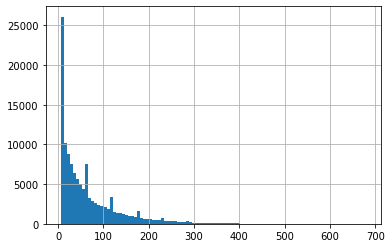

In [10]:
transcript_eda = transcript_df.copy()

# Histogram of time between purchases
transcript_eda["last_time"] = transcript_eda.groupby(["person","event"])["time"].shift(1)
transcript_eda["time_since_last"] = transcript_eda["time"] - transcript_eda["last_time"]
print(transcript_eda["time_since_last"].describe())
transcript_eda.loc[transcript_eda["event"]=="transaction", "time_since_last"].hist(bins=100)

In [11]:
transcript_eda.loc[transcript_eda["event"]=="transaction"].sample(10)

,person,event_no,event,time,amount,offer_id,reward,last_time,time_since_last
250976,d1330d5ce5e742d9826a79d574df3172,19,transaction,594,38.69,NaN,0,432.0,162.0
121570,661aae5a22f046a1ab5c656f5d3e3849,1,transaction,138,2.41,NaN,0,NaN,NaN
257130,d6990e9615924acf80dbdf991238c371,4,transaction,210,15.34,NaN,0,162.0,48.0
251544,d1a6fe4c241e4dbf8a4da6fd6c714ac5,13,transaction,426,15.18,NaN,0,270.0,156.0
93003,4d6ff24523d74ea1b558312278fadcaf,6,transaction,108,1.68,NaN,0,102.0,6.0
83159,45407d4bb6de4e7da3302f931eaa0e87,4,transaction,138,0.56,NaN,0,72.0,66.0
38063,20f7fdd12cc34df7b9ecb67ecd6b05ea,3,transaction,210,16.59,NaN,0,126.0,84.0
176363,9304ae638b864c549c3b24afc9f5dee4,10,transaction,372,11.82,NaN,0,264.0,108.0
60269,32e149f18abe4a0a8555707ea9e99749,5,transaction,264,1.04,NaN,0,246.0,18.0
176783,93668cdc66e24e769b363e4e7692056b,8,transaction,486,2.67,NaN,0,468.0,18.0


In [12]:
portfolio_df

,offer_id,code,offer_type,difficulty,reward,duration,email,mobile,social,web
8,f19421c1d4aa40978ebb69ca19b0e20d,b.5.5.5,bogo,5,5,5,1,1,1,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,b.5.5.7,bogo,5,5,7,1,1,0,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,b.10.10.5,bogo,10,10,5,1,1,1,1
0,ae264e3637204a6fb9bb56bc8210ddfd,b.10.10.7,bogo,10,10,7,1,1,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,d.7.3.7,discount,7,3,7,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,d.10.2.7,discount,10,2,7,1,1,0,1
6,fafdcd668e3743c1bb461111dcafc2a4,d.10.2.10,discount,10,2,10,1,1,1,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,d.20.5.10,discount,20,5,10,1,0,0,1
7,5a8bc65990b245e5a138643cd4eb9837,i.0.0.3,informational,0,0,3,1,1,1,0
2,3f207df678b143eea3cee63160fa8bed,i.0.0.4,informational,0,0,4,1,1,0,1


In [13]:
# Effectiveness of each channel in converting with promotion
promo_funnel = transcript_eda.groupby(["offer_id", "event"]).size().unstack()
promo_funnel = promo_funnel.fillna(0).astype(int)
promo_funnel["view_rate"] = promo_funnel["offer viewed"] / promo_funnel["offer received"]
promo_funnel["comp_rate"] = promo_funnel["offer completed"] / promo_funnel["offer viewed"]
promo_funnel = promo_funnel.reset_index()

portfolio_df.merge(promo_funnel, on="offer_id").sort_values(
    ["offer_type", "difficulty", "reward", "duration"],
    ascending=[True, True, False, False]
)

,offer_id,code,offer_type,difficulty,reward,duration,email,mobile,social,web,offer completed,offer received,offer viewed,view_rate,comp_rate
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,b.5.5.7,bogo,5,5,7,1,1,0,1,4354,7677,4171,0.543311,1.043874
0,f19421c1d4aa40978ebb69ca19b0e20d,b.5.5.5,bogo,5,5,5,1,1,1,1,4296,7571,7264,0.959451,0.591410
3,ae264e3637204a6fb9bb56bc8210ddfd,b.10.10.7,bogo,10,10,7,1,1,1,0,3688,7658,6716,0.876991,0.549136
2,4d5c57ea9a6940dd891ad53e9dbe8da0,b.10.10.5,bogo,10,10,5,1,1,1,1,3331,7593,7298,0.961148,0.456426
4,2298d6c36e964ae4a3e7e9706d1fb8c2,d.7.3.7,discount,7,3,7,1,1,1,1,5156,7646,7337,0.959587,0.702740
6,fafdcd668e3743c1bb461111dcafc2a4,d.10.2.10,discount,10,2,10,1,1,1,1,5317,7597,7327,0.964460,0.725672
5,2906b810c7d4411798c6938adc9daaa5,d.10.2.7,discount,10,2,7,1,1,0,1,4017,7632,4118,0.539570,0.975474
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,d.20.5.10,discount,20,5,10,1,0,0,1,3420,7668,2663,0.347287,1.284266
9,3f207df678b143eea3cee63160fa8bed,i.0.0.4,informational,0,0,4,1,1,0,1,0,7617,4144,0.544046,0.000000
8,5a8bc65990b245e5a138643cd4eb9837,i.0.0.3,informational,0,0,3,1,1,1,0,0,7618,6687,0.877789,0.000000


## Feature Engineering

In [14]:
transcript_df

,person,event_no,event,time,amount,offer_id,reward
0,0009655768c64bdeb2e877511632db8f,1,offer received,168,0.00,5a8bc65990b245e5a138643cd4eb9837,0
1,0009655768c64bdeb2e877511632db8f,2,offer viewed,192,0.00,5a8bc65990b245e5a138643cd4eb9837,0
2,0009655768c64bdeb2e877511632db8f,3,transaction,228,22.16,NaN,0
3,0009655768c64bdeb2e877511632db8f,4,offer received,336,0.00,3f207df678b143eea3cee63160fa8bed,0
4,0009655768c64bdeb2e877511632db8f,5,offer viewed,372,0.00,3f207df678b143eea3cee63160fa8bed,0
...,...,...,...,...,...,...,...
306529,ffff82501cea40309d5fdd7edcca4a07,29,transaction,576,14.23,NaN,0
306530,ffff82501cea40309d5fdd7edcca4a07,30,offer completed,576,0.00,2906b810c7d4411798c6938adc9daaa5,2
306531,ffff82501cea40309d5fdd7edcca4a07,31,offer viewed,582,0.00,2906b810c7d4411798c6938adc9daaa5,0
306532,ffff82501cea40309d5fdd7edcca4a07,32,transaction,606,10.12,NaN,0


In [15]:
transcript_feats = transcript_df.copy()

# Create dummy variables for the events (to perform a cumulative sum)
transcript_feats = pd.concat([transcript_feats, pd.get_dummies(transcript_feats["event"])], axis=1)
transcript_feats["event_no_aux"] = 1

# Define the columns to aggregate, their function and their new name
agg_cols = {
    # original column name: (agg function, agg column name)
    "event_no_aux": ("sum", "event_no"),
    "amount": ("sum", "cum_amount"),
    "reward": ("sum", "cum_reward"),
    "transaction": ("sum", "transactions"),
    "offer received": ("sum", "offers_received"),
    "offer viewed": ("sum", "offers_viewed"),
    "offer completed": ("sum", "offers_completed"),
    "time": ("min", "min_time")
}
aggs = {k: v[0] for k, v in agg_cols.items()}
rename = {k:v[1] for k,v in agg_cols.items()}

# Perform the aggregations on the expanding window partitioned by each person
transcript_aggs = transcript_feats.groupby("person").expanding().agg(aggs)
transcript_aggs = transcript_aggs.rename(columns=rename)
transcript_aggs = transcript_aggs.reset_index().drop(columns="level_1")
transcript_feats = transcript_feats.drop(columns="event_no_aux")
transcript_feats = transcript_feats.merge(transcript_aggs, on=["person", "event_no"])

# Subtract the current "event" so that they account only for the past (without information not available on inference time)
cols_subtract = [col for col in agg_cols.keys() if col not in ["event_no_aux", "time"]]
cols_keep = [rename[col] for col in cols_subtract]
transcript_feats.loc[:, cols_keep] -= transcript_feats.loc[:, cols_subtract].values

# Time since each person's first event
transcript_feats["time_customer"] = transcript_feats["time"] - transcript_feats["min_time"]
transcript_feats = transcript_feats.drop(columns="min_time")

# Average transaction value (up to that point)
transcript_feats["atv"] = transcript_feats["cum_amount"] / transcript_feats["transactions"]
# Percentage of offers completed (completed / received) - up to that point
transcript_feats["offer_usage"] = transcript_feats["offers_completed"] / transcript_feats["offers_received"]

transcript_feats.head(25)


# transcript_feats["cum_amount"] = transcript_feats.groupby("person")["amount"].transform(pd.Series.cumsum)
# transcript_feats["cum_amount"] -= transcript_feats["amount"]
# transcript_feats["cum_reward"] = transcript_feats.groupby("person")["reward"].transform(pd.Series.cumsum)
# transcript_feats["cum_reward"] -= transcript_feats["reward"]

# feat_map = {
#     "transaction":     "transactions",
#     "offer received":  "offers_received",
#     "offer viewed":    "offers_viewed",
#     "offer completed": "offers_completed"
# }

# for dummy_col, feat in feat_map.items():
#     transcript_feats[feat] = transcript_feats.groupby("person")[dummy_col].transform(pd.Series.cumsum)
#     transcript_feats[feat] -= transcript_feats[dummy_col]
# # Drop dummy columns
# transcript_feats = transcript_feats.drop(columns=feat_map.keys())

,person,event_no,event,time,amount,offer_id,reward,spending,cum_reward,transactions,...,d.10.2.7,d.20.5.10,d.7.3.7,i.0.0.3,i.0.0.4,age,income,became_member_on,F,M
0,0009655768c64bdeb2e877511632db8f,1,offer received,168,0.00,5a8bc65990b245e5a138643cd4eb9837,0,0.000000e+00,0.0,0.0,...,0,0,0,1,0,33,72000.0,1492732800000000000,0,1
1,0009655768c64bdeb2e877511632db8f,2,offer viewed,192,0.00,5a8bc65990b245e5a138643cd4eb9837,0,0.000000e+00,0.0,0.0,...,0,0,0,1,0,33,72000.0,1492732800000000000,0,1
2,0009655768c64bdeb2e877511632db8f,3,transaction,228,22.16,NaN,0,0.000000e+00,0.0,0.0,...,0,0,0,1,0,33,72000.0,1492732800000000000,0,1
3,0009655768c64bdeb2e877511632db8f,4,offer received,336,0.00,3f207df678b143eea3cee63160fa8bed,0,2.216000e+01,0.0,1.0,...,0,0,0,0,1,33,72000.0,1492732800000000000,0,1
4,0009655768c64bdeb2e877511632db8f,5,offer viewed,372,0.00,3f207df678b143eea3cee63160fa8bed,0,2.216000e+01,0.0,1.0,...,0,0,0,0,1,33,72000.0,1492732800000000000,0,1
5,0009655768c64bdeb2e877511632db8f,6,offer received,408,0.00,f19421c1d4aa40978ebb69ca19b0e20d,0,2.216000e+01,0.0,1.0,...,0,0,0,0,1,33,72000.0,1492732800000000000,0,1
6,0009655768c64bdeb2e877511632db8f,7,transaction,414,8.57,NaN,0,2.216000e+01,0.0,1.0,...,0,0,0,0,1,33,72000.0,1492732800000000000,0,1
7,0009655768c64bdeb2e877511632db8f,8,offer completed,414,0.00,f19421c1d4aa40978ebb69ca19b0e20d,5,3.073000e+01,0.0,2.0,...,0,0,0,0,1,33,72000.0,1492732800000000000,0,1
8,0009655768c64bdeb2e877511632db8f,9,offer viewed,456,0.00,f19421c1d4aa40978ebb69ca19b0e20d,0,3.073000e+01,5.0,2.0,...,0,0,0,0,0,33,72000.0,1492732800000000000,0,1
9,0009655768c64bdeb2e877511632db8f,10,offer received,504,0.00,fafdcd668e3743c1bb461111dcafc2a4,0,3.073000e+01,5.0,2.0,...,0,0,0,0,0,33,72000.0,1492732800000000000,0,1


In [16]:
# Create training dataset
X_df = transcript_feats[transcript_feats["event"]=="offer received"].copy()
Y_df = transcript_feats[transcript_feats["event"]=="transaction"].copy()
# 2. Create "passive"/"observational" samples to train regression model

# Create regression model to predict spending
# Make sure dataset is balanced with the offers
# 1. Drop correlated features / Make feature eng (mainly interactions)
# 2. Split train and tests datasets (sample customers and customer events occurring after xx% of their timeline length)
# 3. Normalize features
# 4. Train regression model
# 5. Assess errors in the three regions defined by step 2
# 6. Assess coefficients for the boolean features for valid offers

display(X_df.head())
display(Y_df.head())

,person,event_no,event,time,amount,offer_id,reward,spending,cum_reward,transactions,...,d.10.2.7,d.20.5.10,d.7.3.7,i.0.0.3,i.0.0.4,age,income,became_member_on,F,M
0,0009655768c64bdeb2e877511632db8f,1,offer received,168,0.0,5a8bc65990b245e5a138643cd4eb9837,0,0.00,0.0,0.0,...,0,0,0,1,0,33,72000.0,1492732800000000000,0,1
3,0009655768c64bdeb2e877511632db8f,4,offer received,336,0.0,3f207df678b143eea3cee63160fa8bed,0,22.16,0.0,1.0,...,0,0,0,0,1,33,72000.0,1492732800000000000,0,1
5,0009655768c64bdeb2e877511632db8f,6,offer received,408,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0,22.16,0.0,1.0,...,0,0,0,0,1,33,72000.0,1492732800000000000,0,1
9,0009655768c64bdeb2e877511632db8f,10,offer received,504,0.0,fafdcd668e3743c1bb461111dcafc2a4,0,30.73,5.0,2.0,...,0,0,0,0,0,33,72000.0,1492732800000000000,0,1
14,0009655768c64bdeb2e877511632db8f,15,offer received,576,0.0,2906b810c7d4411798c6938adc9daaa5,0,58.40,7.0,4.0,...,1,0,0,0,0,33,72000.0,1492732800000000000,0,1


,person,event_no,event,time,amount,offer_id,reward,spending,cum_reward,transactions,...,d.10.2.7,d.20.5.10,d.7.3.7,i.0.0.3,i.0.0.4,age,income,became_member_on,F,M
2,0009655768c64bdeb2e877511632db8f,3,transaction,228,22.16,NaN,0,0.00,0.0,0.0,...,0,0,0,1,0,33,72000.0,1492732800000000000,0,1
6,0009655768c64bdeb2e877511632db8f,7,transaction,414,8.57,NaN,0,22.16,0.0,1.0,...,0,0,0,0,1,33,72000.0,1492732800000000000,0,1
10,0009655768c64bdeb2e877511632db8f,11,transaction,528,14.11,NaN,0,30.73,5.0,2.0,...,0,0,0,0,0,33,72000.0,1492732800000000000,0,1
13,0009655768c64bdeb2e877511632db8f,14,transaction,552,13.56,NaN,0,44.84,7.0,3.0,...,0,0,0,0,0,33,72000.0,1492732800000000000,0,1
15,0009655768c64bdeb2e877511632db8f,16,transaction,576,10.27,NaN,0,58.40,7.0,4.0,...,1,0,0,0,0,33,72000.0,1492732800000000000,0,1


In [125]:
from tqdm import tqdm

time_windows = sorted(24*portfolio_df["duration"].unique())

spendings = []
for p in tqdm(transcript_feats["person"].unique()):
    pdf = transcript_feats[transcript_feats["person"]==p]
    received_offers = pdf[pdf["event"]=="offer received"]
    transactions = pdf[pdf["event"]=="transaction"]

    person_spendings = []
    for _, offer in received_offers.iterrows():
        event_no = offer["event_no"]
        time_offer = offer["time"]
        
        future_transactions = transactions[transactions["event_no"]>event_no]
        window_spendings = {"person": p, "event_no": event_no}
        for time_window in time_windows:
            window_mask = future_transactions["time"] < (time_offer+time_window)
            window_spendings[time_window] = future_transactions.loc[window_mask,"amount"].sum()

        person_spendings.append(window_spendings)

    spendings += person_spendings
    if len(spendings) > 1000:
        break

# aux = aux.drop(columns=["event","offer_code","offer_duration"]).loc[rep_index]
# aux["time"] += aux.groupby(["person","event_no"]).cumcount()

# aux = aux.drop(columns="event_no").groupby(["person","time"], as_index=False).max()
# transcript_feats = transcript_feats.merge(aux, on=["person","time"], how="left")
# for offer in portfolio_df["code"]:
#     # Records need to be filled with 0s because at the record time, no offers were valid
#     transcript_feats[offer] = transcript_feats[offer].fillna(0).astype(int)

  1%|▏         | 224/17000 [00:11<13:48, 20.25it/s]


In [126]:
pd.DataFrame(spendings)

,person,event_no,72,96,120,168,240
0,0009655768c64bdeb2e877511632db8f,1,22.16,22.16,22.16,22.16,22.16
1,0009655768c64bdeb2e877511632db8f,4,0.00,8.57,8.57,8.57,36.24
2,0009655768c64bdeb2e877511632db8f,6,8.57,8.57,8.57,36.24,46.51
3,0009655768c64bdeb2e877511632db8f,10,27.67,37.94,37.94,50.30,96.87
4,0009655768c64bdeb2e877511632db8f,15,10.27,22.63,50.79,69.20,69.20
...,...,...,...,...,...,...,...
999,0375600415e24e0a9fd83ec191d5955d,10,21.96,21.96,26.25,26.25,26.25
1000,037c3e0c1cd6477dbe15812a05619fc5,1,0.00,0.00,0.00,0.00,0.00
1001,037c3e0c1cd6477dbe15812a05619fc5,2,0.00,0.00,20.89,29.61,64.28
1002,037c3e0c1cd6477dbe15812a05619fc5,10,0.00,0.00,22.73,44.95,44.95


In [134]:
# Auxiliary variables
dummy_base_ts = pd.Timestamp("2021-01-01")
last_event_ts = dummy_base_ts + pd.to_timedelta(transcript_df["time"].max(), "h")
time_windows = sorted(24*portfolio_df["duration"].unique())

# Filter only relevant columns and rows
target_df = transcript_feats[["person","time","event","amount"]].copy()
target_df = target_df[target_df["event"].isin(["offer received", "transaction"])]

# ALTERAR
Y_df = target_df.copy()

# Add dummy events in the future (to make sure it exists an event at time t+time_window
# for every event occurring at time t) - this is done because rolling is only performed
# for previous rows
dummy_events = target_df.copy().rename(columns={"time": "orig_time"})
dummy_events["amount"] = 0
for time_window in time_windows:
    dummy_events["time"] = dummy_events["orig_time"] + time_window
    target_df = pd.concat([target_df, dummy_events.drop(columns="orig_time")])

# Group concurrent events
target_df["ts"] = dummy_base_ts + pd.to_timedelta(target_df["time"], "h")
target_df = target_df.drop(columns="time")
target_df = target_df.groupby(["person","ts"], as_index=False).sum()

# Calculate the future spending for each time window (offer durations)
for time_window in time_windows:
    # Rolling sums (closed on the left endpoint so that transactions occurring at the same time, i.e. hour,
    # are included in the future spending)
    rs = target_df.groupby("person", as_index=False).rolling(f"{time_window}h", on="ts", closed="left").sum()
    rs_spending_col_name = f"spending_next_{time_window}h"
    rs = rs.rename(columns={"amount": rs_spending_col_name})

    # Set spendings to NA if time window contains events after the last time in the dataset
    rs[rs_spending_col_name] = rs[rs_spending_col_name].where(rs["ts"] < last_event_ts)

    # Shifts events by the time_window so that the rolling sum is over the future
    rs["time"] = (rs["ts"]-dummy_base_ts).dt.total_seconds()/3600 - time_window
    rs["time"] = rs["time"].astype(int)
    rs = rs.drop(columns="ts")

    Y_df = Y_df.merge(rs, on=["person","time"], how="left")

Y_df = Y_df[Y_df["event"]=="offer received"]
Y_df = Y_df.drop(columns=["event","amount"])

In [136]:
Y_df.head(10)

,person,time,spending_next_72h,spending_next_96h,spending_next_120h,spending_next_168h,spending_next_240h
0,0009655768c64bdeb2e877511632db8f,168,22.16,22.16,22.16,22.16,22.16
2,0009655768c64bdeb2e877511632db8f,336,0.00,8.57,8.57,8.57,36.24
3,0009655768c64bdeb2e877511632db8f,408,8.57,8.57,8.57,36.24,46.51
5,0009655768c64bdeb2e877511632db8f,504,27.67,37.94,37.94,50.30,NaN
8,0009655768c64bdeb2e877511632db8f,576,10.27,22.63,50.79,NaN,NaN
13,00116118485d4dfda04fdbaba9a87b5c,168,0.00,0.00,0.00,0.70,0.70
17,00116118485d4dfda04fdbaba9a87b5c,576,0.00,0.00,0.00,NaN,NaN
18,0011e0d4e6b944f998e987f904e8c1e5,0,0.00,0.00,0.00,13.49,13.49
20,0011e0d4e6b944f998e987f904e8c1e5,168,0.00,11.93,11.93,11.93,11.93
22,0011e0d4e6b944f998e987f904e8c1e5,336,0.00,0.00,0.00,0.00,0.00


In [218]:
# Check if customers can have more than one of the same offer valid at a time
aux = transcript_feats.copy()[["person","time","event","offer_code","offer_duration"]]
aux = aux[aux["event"]=="offer received"]
aux["offer_duration"] = (24*aux["offer_duration"]).astype(int)
aux["offer_valid_until"] = aux["time"] + aux["offer_duration"]

aux["offer_id_no"] = aux.groupby(["person","offer_code"]).cumcount() + 1
aux["last_offer_id_valid_until"] = aux.groupby(["person","offer_code"])["offer_valid_until"].shift(1)

aux["previous_same_offer_valid"] = aux["time"] < aux["last_offer_id_valid_until"]

aux = aux.drop(columns=["offer_duration"])
if aux["previous_same_offer_valid"].any():
    print("There are cases where a person receives a specific offer eventhough he/she had previously received it and it is still valid")
else:
    print("An offer is only sent if the customer doesn't have that same offer still valid")
aux.tail()

There are cases where a person receives a specific offer eventhough he/she had previously received it and it is still valid


,person,time,event,offer_code,offer_valid_until,offer_id_no,last_offer_id_valid_until,previous_same_offer_valid
306507,ffff82501cea40309d5fdd7edcca4a07,168,offer received,d.20.5.10,408,1,NaN,False
306515,ffff82501cea40309d5fdd7edcca4a07,336,offer received,d.10.2.7,504,1,NaN,False
306519,ffff82501cea40309d5fdd7edcca4a07,408,offer received,d.10.2.7,576,2,504.0,True
306524,ffff82501cea40309d5fdd7edcca4a07,504,offer received,b.5.5.7,672,1,NaN,False
306528,ffff82501cea40309d5fdd7edcca4a07,576,offer received,d.10.2.7,744,3,576.0,False


In [219]:
transcript_feats = transcript_df.copy()

# Create cumulative amount spent and cumulative amount rewarded (up to that point)
print(">> Step 1: Cumulative amount spent and cumulative amount rewarded")
transcript_feats["cum_amount"] = transcript_feats.groupby("person")["amount"].transform(pd.Series.cumsum)
transcript_feats["cum_amount"] -= transcript_feats["amount"]
transcript_feats["cum_reward"] = transcript_feats.groupby("person")["reward"].transform(pd.Series.cumsum)
transcript_feats["cum_reward"] -= transcript_feats["reward"]

# Create number of transactions, offers received, offers viewed and offers completed
print(">> Step 2: Number of transactions, offers received, offers viewed and offers completed")
feat_map = {
    "transaction":     "transactions",
    "offer received":  "offers_received",
    "offer viewed":    "offers_viewed",
    "offer completed": "offers_completed"
}
transcript_feats = pd.concat([transcript_feats, pd.get_dummies(transcript_feats["event"])], axis=1)
for dummy_col, feat in feat_map.items():
    transcript_feats[feat] = transcript_feats.groupby("person")[dummy_col].transform(pd.Series.cumsum)
    transcript_feats[feat] -= transcript_feats[dummy_col]
# Drop dummy columns
transcript_feats = transcript_feats.drop(columns=feat_map.keys())

print(">> Step 3: Simple feature interactions")
# Average transaction value (up to that point)
transcript_feats["atv"] = transcript_feats["cum_amount"] / transcript_feats["transactions"]
# Percentage of offers completed (completed / received) - up to that point
transcript_feats["offer_usage"] = transcript_feats["offers_completed"] / transcript_feats["offers_received"]

# Time since last transaction, offer received, offer viewed, and offer completed
transcript_feats["last_time"] = transcript_feats.groupby(["person","event"])["time"].shift(1)
transcript_feats["time_since_last"] = transcript_feats["time"] - transcript_feats["last_time"]
transcript_feats = transcript_feats.drop(columns="last_time")

# Time since each person's first event
first_events = transcript_feats.groupby("person")["time"].min().reset_index().rename(columns={"time": "min_time"})
transcript_feats = transcript_feats.merge(first_events, on="person", how="left")
transcript_feats["time_customer"] = transcript_feats["time"] - transcript_feats["min_time"]
transcript_feats = transcript_feats.drop(columns="min_time")

# Number of features in last 7/14/21 days (number of transactions in the last x days)
# replace by mean and mode times of purchases
# Actually, make the "momentum": sum of the inverse of time differences: sum(1/(today - time_purchase[k]))
# or use the exponential smoothing

# Z-Score of time between purchases (time since last transaction - avg) / std
transcript_feats["time_since_last_purchase"] = transcript_feats["time_since_last"].where(transcript_feats["event"]=="transaction")
transcript_feats["sum_time_since_last_purchase"] = transcript_feats.groupby(["person","event"])["time_since_last_purchase"].transform(pd.Series.cumsum)
transcript_feats["avg_time_between_purchases"] = transcript_feats["sum_time_since_last_purchase"] / transcript_feats["transactions"]
transcript_feats.loc[transcript_feats["event"]!="transaction", "avg_time_between_purchases"] = np.nan
#transcript_feats["std_time_between_purchases"] = transcript_feats.groupby()

# Join with portfolio and get the percentage the reward represent of the ATV

# Effectiveness of each channel

transcript_feats.head(20)

>> Step 1: Cumulative amount spent and cumulative amount rewarded
>> Step 2: Number of transactions, offers received, offers viewed and offers completed


KeyboardInterrupt: 

In [ ]:
transcript_feats[transcript_feats["person"]=="ffff82501cea40309d5fdd7edcca4a07"]